# Linear Regression

## Import necessary libraries and dataframes 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.feature_selection import RFE
import seaborn as sns
sns.set_style('darkgrid')

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline

import StatsFunctions as sf

In [2]:
#importing cvs files and saving them under a variable
kc_house_df = pd.read_csv("kc_df_cleaned.csv")
kc_house_df.head()

,price,bedrooms,sqft_living,sqft_lot,floors,condition,grade,zipcode,lat,long
0,538000.0,3,2570,7242,2.0,3,7,98125,47.7210,-122.319
1,180000.0,2,770,10000,1.0,3,6,98028,47.7379,-122.233
2,604000.0,4,1960,5000,1.0,5,7,98136,47.5208,-122.393
3,510000.0,3,1680,8080,1.0,3,8,98074,47.6168,-122.045
4,257500.0,3,1715,6819,2.0,3,7,98003,47.3097,-122.327


In [3]:
kc_house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17925 entries, 0 to 17924
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        17925 non-null  float64
 1   bedrooms     17925 non-null  int64  
 2   sqft_living  17925 non-null  int64  
 3   sqft_lot     17925 non-null  int64  
 4   floors       17925 non-null  float64
 5   condition    17925 non-null  int64  
 6   grade        17925 non-null  int64  
 7   zipcode      17925 non-null  int64  
 8   lat          17925 non-null  float64
 9   long         17925 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 1.4 MB


In [4]:
df_cont_log = pd.read_csv("df_cont_log_cleaned.csv")
df_cont_log.head()

,price_log,sqft_living_log
0,0.380995,0.823169
1,-1.927823,-2.213002
2,0.625004,0.140596
3,0.268290,-0.247722
4,-1.172776,-0.195780


***
## One-Hot Encoding categorcial features

I will use one-hot encoding to transfrom categorical columns into binary variables 

In [5]:
kc_house_df.head()

,price,bedrooms,sqft_living,sqft_lot,floors,condition,grade,zipcode,lat,long
0,538000.0,3,2570,7242,2.0,3,7,98125,47.7210,-122.319
1,180000.0,2,770,10000,1.0,3,6,98028,47.7379,-122.233
2,604000.0,4,1960,5000,1.0,5,7,98136,47.5208,-122.393
3,510000.0,3,1680,8080,1.0,3,8,98074,47.6168,-122.045
4,257500.0,3,1715,6819,2.0,3,7,98003,47.3097,-122.327


In [6]:
categoricals = ['bedrooms', 'floors', 'condition', 'grade']

cat_series = kc_house_df[categoricals]
df_cat = cat_series.astype('category')

In [7]:
df_cat.dtypes

bedrooms     category
floors       category
condition    category
grade        category
dtype: object

In [8]:
df_cat_ohe = pd.get_dummies(df_cat, prefix=categoricals, drop_first = True)

***
## Now, we combine the categorical and continous features

In [9]:
# combine features into a single dataframe called preprocessed
preprocessed = pd.concat([df_cont_log, df_cat_ohe], axis=1)
preprocessed.head()

,price_log,sqft_living_log,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,floors_1.5,floors_2.0,floors_2.5,floors_3.0,condition_3,condition_4,condition_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11
0,0.380995,0.823169,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0
1,-1.927823,-2.213002,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,0.625004,0.140596,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,0.268290,-0.247722,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,-1.172776,-0.195780,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0


***
## Check for linearity

I will create a plot of continuous variables using Seaborn to determine if the target variable ('price_log') is linearly related to the input features

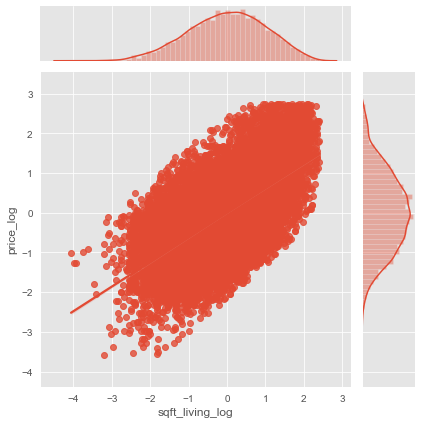

In [10]:
sns.jointplot('sqft_living_log', 'price_log', data=preprocessed, kind='reg')

Kinda hard to see but there is a linear relationship between the two.

***
## Fitting an initial model

In [11]:
features = list(preprocessed.drop('price_log', axis=1))

In [12]:
print(features)

['sqft_living_log', 'bedrooms_2', 'bedrooms_3', 'bedrooms_4', 'bedrooms_5', 'bedrooms_6', 'floors_1.5', 'floors_2.0', 'floors_2.5', 'floors_3.0', 'condition_3', 'condition_4', 'condition_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_11']


In [13]:
# Conduct train and test split
train, test = train_test_split(preprocessed)

In [14]:
print(len(train), len(test))
train.head()

13443 4482


,price_log,sqft_living_log,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,floors_1.5,floors_2.0,floors_2.5,floors_3.0,condition_3,condition_4,condition_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11
4259,2.543174,1.153411,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
13977,1.217628,1.335792,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
1635,1.295257,0.350126,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
183,1.830842,1.873802,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
5713,0.118370,0.048983,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


In [15]:
model = sf.check_model(df=train, features_to_use=features, target_col='price_log', show_summary=True)

sqft_living_log surpassed threshold with vif=3.0505356549881024
Model contains multicollinear features
                                 OLS Regression Results                                
Dep. Variable:              price_log   R-squared (uncentered):                   0.521
Model:                            OLS   Adj. R-squared (uncentered):              0.521
Method:                 Least Squares   F-statistic:                              769.9
Date:                Sun, 18 Oct 2020   Prob (F-statistic):                        0.00
Time:                        19:48:20   Log-Likelihood:                         -14130.
No. Observations:               13443   AIC:                                  2.830e+04
Df Residuals:                   13424   BIC:                                  2.844e+04
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
                 

In [18]:
# Trying to remove uninfluential features
summary = model.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
print(len(p_table), len(x_cols))
print(x_cols[:5])
p_table.head()

19 17
['sqft_living_log', 'bedrooms_2', 'bedrooms_3', 'bedrooms_4', 'bedrooms_5']


,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
sqft_living_log,0.4238,0.010,40.679,0.0,0.403,0.444
bedrooms_2,-0.4749,0.059,-8.060,0.0,-0.590,-0.359
bedrooms_3,-0.8476,0.059,-14.434,0.0,-0.963,-0.733
bedrooms_4,-0.9000,0.060,-14.974,0.0,-1.018,-0.782
bedrooms_5,-0.8455,0.064,-13.217,0.0,-0.971,-0.720


In [17]:
model = sf.check_model(df=train, features_to_use=features, target_col='price_log', show_summary=True)

sqft_living_log surpassed threshold with vif=3.0505356549881024
Model contains multicollinear features
                                 OLS Regression Results                                
Dep. Variable:              price_log   R-squared (uncentered):                   0.521
Model:                            OLS   Adj. R-squared (uncentered):              0.521
Method:                 Least Squares   F-statistic:                              769.9
Date:                Sun, 18 Oct 2020   Prob (F-statistic):                        0.00
Time:                        19:49:27   Log-Likelihood:                         -14130.
No. Observations:               13443   AIC:                                  2.830e+04
Df Residuals:                   13424   BIC:                                  2.844e+04
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
                 